In [1]:
# Requirements: Packages being used:
%pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.15.0
backcall                         0.2.0
beautifulsoup4                   4.12.3
bidict                           0.23.1

In [2]:
# Loading Packages
import pandas as pd
import numpy as np

In [3]:
# Exploratory Data Analysis
df = pd.read_csv("search_queries.csv")

In [4]:
print("DF shape:", df.shape)

df.head()

DF shape: (599, 8)


,date,search_query,market,geo_country,device_type,browser_name,intent,daily_query_count
0,2023-12-08,google translate,en-gb,GB,Desktop,Chrome,TRANSLATION,2
1,2023-12-08,rephrase,en-gb,GB,Desktop,Chrome,DICTIONARY,2
2,2023-12-31,amazon,en-gb,GB,Mobile,Chrome,NAVIGATION,2
3,2023-12-29,facebook,fr-fr,FR,Mobile,Ecosia ios,NAVIGATION,3
4,2023-12-23,tv programm,de-de,DE,Mobile,Safari,OTHER,3


Intent Categories + Counts: 
 intent
OTHER          173
QA             109
TRANSLATION    100
SHOPPING        66
NAVIGATION      60
DICTIONARY      19
WEATHER          5
COMPUTATION      5
Name: count, dtype: int64 



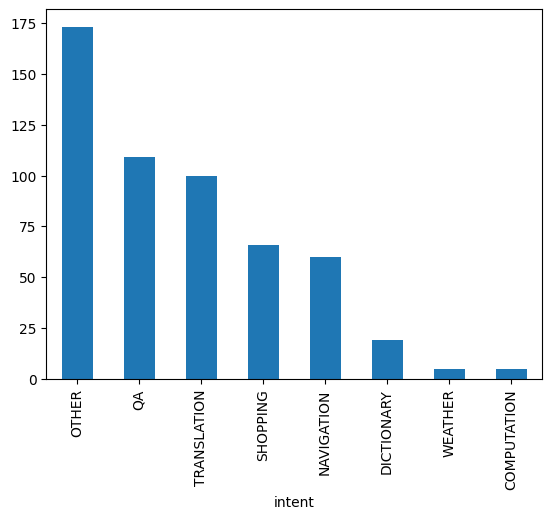

In [5]:
from typing_extensions import Annotated
# Breakdown of intent categories
print("Intent Categories + Counts: \n", df['intent'].value_counts(), "\n")

ax = df.intent.value_counts().plot.bar()

In [6]:
# Breakdown of Queries by Country
print("Country Categories + Counts: \n", df['geo_country'].value_counts(), "\n")

# Printing Examples of the Types of Search Queries (In English)
print("English Search Queries Examples: \n", df[(df.geo_country) == 'GB']['search_query'].unique(), "\n")

Country Categories + Counts: 
 geo_country
FR    213
DE    204
GB    105
CN      6
US      3
AT      3
GH      1
Name: count, dtype: int64 

English Search Queries Examples: 
 ['google translate' 'rephrase' 'amazon' 'weather ' 'etsy' 'outlook'
 'boots' 'Recruiting' 'grammarly' 'front door handle' 'google'
 'hotel chocolat uk' 'indeed jobs' 'google scholar' 'setofilm 4 mg'
 'bill granger' 'gmail' 'tesco groceries' 'apple tv' 'translate' 'next'
 'vivobarefoot uk' 'minerva' 'yahoo mail' 'epiphany in welsh'
 'steve cooper' 'esr' 'lincoln' 'zoopla' 'wordle' 'guardian' 'tfl'
 'weather' 'lg 38 ultrawide' 'chatgpt' 'Basketball' 'john lewis'
 'bbc iplayer' 'mens under armour graphic fleece' 'schuh' 'deliveroo'
 'sainsburys' 'amazon uk' 'chanel coco mademoiselle set'
 'victorian engagement ring' 'sketchpad' 'calculator' 'paypal login'
 'google drive' 'guardian uk' 'yahoo' 'nhs jobs' "sainsbury's groceries"
 'maps' 'PR' 'bbc news' 'glow' 'tony robbins' 'argos' 'parasite' 'nhsmail'
 'spotify' 'bbc

There is a noticeable class imbalance on the "intent" column.

The "geo_country" looks standardized.

Looking at the sample of queries in the cell above, you can see some various characters/punctuations, numeric values, and not many stop words. We will remove them just in case during the preprocessing stage.


In [7]:
# Data Quality Checks

#missing_intent
print("Number of missing values in intent column:", df['intent'].isnull().sum(), "\n")

missing_intent = df.loc[df['intent'].isnull()]

print("Country queries of missing data: \n", missing_intent.geo_country.value_counts())

missing_intent.head(5)

Number of missing values in intent column: 62 

Country queries of missing data: 
 geo_country
DE    10
FR     9
GB     5
Name: count, dtype: int64


,date,search_query,market,geo_country,device_type,browser_name,intent,daily_query_count
6,2023-12-07,weather,NaN,GB,Mobile,Chromium,NaN,2
7,2023-12-28,vorwissenschaftliche arbeit,de-de,NaN,Desktop,Chrome,NaN,2
21,2024-01-05,ikea,de-de,NaN,Desktop,Chrome,NaN,2
24,2023-12-28,ecksofa mit schlaffunktion,NaN,NaN,NaN,NaN,NaN,2
27,2023-12-13,blumenkohl und brokkoli im backofen,de-de,DE,NaN,NaN,NaN,2


In [8]:
print("Number of missing values in search_query column:", df['search_query'].isnull().sum(), "\n")

Number of missing values in search_query column: 0 



# Overall Analysis & Preprocessing Approach

1) Convert search_query to one language, English specifically

2) For the model, I will be using the search_query and intent columns for analysis. Date, market, device_type, browser_name, and daily_query_count are helpful metrics for other types of analysis, however these data values typically do not influence the intent of a query. For this first pass, I will not include them.

3) Preprocessing steps:

*   Remove rows where intent is missing
*   Convert "search_query" column all to one language
*   Convert "intent" column to numerical categories
*   Preprocess "search_query" data, remove stop words, remove puntuations, and conduct lemma  
*   Address class imbalance issue in "intent" column
*   TF-IDF approach on "search_query" colum
*   Test out NaiveBayes vs KNN vs Gradient Boost Classifiers



In [9]:
# Remove rows of data without intent

df_intent = df.dropna(subset=['intent'])

print("New dataframe shape: \n", df_intent.shape)

New dataframe shape: 
 (537, 8)


In [10]:
# Creating a new column for translated search queries
!pip install -U deep-translator
# Documentation: https://pypi.org/project/deep-translator/

from deep_translator import GoogleTranslator

# Creating a Function that will detect the language of the query and translate it if it's not in english
def translate_to_english(text):
  target_language = 'en'
  translated_text = GoogleTranslator(source='auto',
                                     target=target_language).translate(text)
  return translated_text


# Testing Function
print("Translating 'traduction anglais français' to English:",
      translate_to_english('traduction anglais français'), "\n")


# Creating New Translated Search Query Column
df_intent['translated_txt'] = df_intent.search_query.apply(lambda x: translate_to_english(x))

Translating 'traduction anglais français' to English: English French translation 



<ipython-input-10-5c61af41c1c9>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intent['translated_txt'] = df_intent.search_query.apply(lambda x: translate_to_english(x))


In [11]:
# Checking if Query Translation Occured:
df_intent.loc[df_intent["geo_country"] =='FR'].head()

,date,search_query,market,geo_country,device_type,browser_name,intent,daily_query_count,translated_txt
3,2023-12-29,facebook,fr-fr,FR,Mobile,Ecosia ios,NAVIGATION,3,facebook
8,2023-12-17,vacances scolaires 2023 2024,fr-fr,FR,Mobile,Chromium,QA,4,school holidays 2023 2024
9,2023-12-14,traduction,fr-fr,FR,Desktop,Chrome,TRANSLATION,2,translation
10,2024-01-01,gens definition,fr-fr,FR,Mobile,Edge,DICTIONARY,2,gens definition
11,2023-12-19,twitch,fr-fr,FR,Desktop,Chrome,OTHER,3,twitch


In [12]:
# Preprocess Search Query text - Remove punctuations, stop words, and conducting lemmatization

import spacy
!spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    doc = nlp(text)

    filtered_tokens = []
    for token in doc:
        # Removing stop words and punctuation
        if token.is_stop or token.is_punct:
            continue
        # taking the lemma token
        filtered_tokens.append(token.lemma_)

    return " ".join(filtered_tokens)


# Testing the function:
# print(preprocess_and_vectorize_text("I want to eat bananas"))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 20.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [13]:
# Applying function to the queries in df_intent
df_intent['clean_txt'] = df_intent['translated_txt'].apply(lambda x: preprocess_text(x))

<ipython-input-13-3c5f6f230f58>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intent['clean_txt'] = df_intent['translated_txt'].apply(lambda x: preprocess_text(x))


In [14]:
df_intent.head()

,date,search_query,market,geo_country,device_type,browser_name,intent,daily_query_count,translated_txt,clean_txt
0,2023-12-08,google translate,en-gb,GB,Desktop,Chrome,TRANSLATION,2,google translate,google translate
1,2023-12-08,rephrase,en-gb,GB,Desktop,Chrome,DICTIONARY,2,rephrase,rephrase
2,2023-12-31,amazon,en-gb,GB,Mobile,Chrome,NAVIGATION,2,amazon,amazon
3,2023-12-29,facebook,fr-fr,FR,Mobile,Ecosia ios,NAVIGATION,3,facebook,facebook
4,2023-12-23,tv programm,de-de,DE,Mobile,Safari,OTHER,3,TV program,tv program


### Address class imbalance issue in "intent" column

Now we will address the class imbalance issue with the intent categories.

As a reference, here are the category counts from the dataset:

*   OTHER - 173
*   QA - 109
*   TRANSLATION - 100
*   SHOPPING - 66
*   NAVIGATION - 60
*   DICTIONARY - 19
*   WEATHER - 5
*   COMPUTATION - 5

Since "WEATHER", "COMPUTATION", and "DICTIONARY" are such small categories, I will remove these samples all together for this analysis.

Since "OTHER" category is so large, I will take a 109 random sample to become more aligned with the "QA" and "TRANSLATION" categories, **however due to time, I will not be able to for this assignment**.   

Regarding undersampling, I would apply a Synthetic Minority Over-sampling Technique (SMOTE) to the "SHOPPING", "NAVIGATION", and "DICTIONARY" columns, **however due to time, I will not be able to for this assignment**.  

Ideally for real life projects, we want to make sure our training dataset is robust and has equal representation of all intent categories we're interested in.

In [15]:
# Removing "WEATHER" and "COMPUTATION" categories

print("Before removing columns:", df_intent.shape, "\n")

df_intent = df_intent.loc[df_intent["intent"].isin(["OTHER", "QA", "TRANSLATION", "SHOPPING", "NAVIGATION"])]

print("After removing columns:", df_intent.shape, "\n")


# Convert Intent Column to Numerical Categories

df_intent['intent_num'] = df_intent.intent.map({
    "OTHER": 0,
    "QA": 1,
    "TRANSLATION": 2,
    "SHOPPING": 3,
    "NAVIGATION": 4
})

df_intent.head()

Before removing columns: (537, 10) 

After removing columns: (508, 10) 



<ipython-input-15-c1c219cb0dc1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intent['intent_num'] = df_intent.intent.map({


,date,search_query,market,geo_country,device_type,browser_name,intent,daily_query_count,translated_txt,clean_txt,intent_num
0,2023-12-08,google translate,en-gb,GB,Desktop,Chrome,TRANSLATION,2,google translate,google translate,2
2,2023-12-31,amazon,en-gb,GB,Mobile,Chrome,NAVIGATION,2,amazon,amazon,4
3,2023-12-29,facebook,fr-fr,FR,Mobile,Ecosia ios,NAVIGATION,3,facebook,facebook,4
4,2023-12-23,tv programm,de-de,DE,Mobile,Safari,OTHER,3,TV program,tv program,0
5,2023-12-11,fußmatten ford focus kombi,de-de,DE,Mobile,Chrome,SHOPPING,2,floor mats ford focus station wagon,floor mat ford focus station wagon,3


## ML Models:

In [16]:
# Creating train and test datasets:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_intent.clean_txt,
    df_intent.intent_num,
    test_size = 0.2,
    random_state = 9876,
    stratify=df_intent.intent_num
)

# Applying TF-IDF Vectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
X_train_cv = v.fit_transform(X_train)
X_test_cv = v.transform(X_test)


In [17]:
X_train_cv.toarray()[:2][0].shape

(410,)

In [18]:
print("Examining the category distribution between test and training datasets: \n")

print("Training Intent Categories Count: \n", y_train.value_counts(), "\n")

print("Testing Intent Categories Count: \n",y_test.value_counts(), "\n")

Examining the category distribution between test and training datasets: 

Training Intent Categories Count: 
 intent_num
0    138
1     87
2     80
3     53
4     48
Name: count, dtype: int64 

Testing Intent Categories Count: 
 intent_num
0    35
1    22
2    20
3    13
4    12
Name: count, dtype: int64 



### Model #1: Naive Bayes Classification

In [19]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train_cv, y_train)

from sklearn.metrics import classification_report
y_pred = clf.predict(X_test_cv)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.54      0.77      0.64        35
           1       0.50      0.36      0.42        22
           2       0.87      1.00      0.93        20
           3       1.00      0.31      0.47        13
           4       0.89      0.67      0.76        12

    accuracy                           0.66       102
   macro avg       0.76      0.62      0.64       102
weighted avg       0.70      0.66      0.64       102



### Model #2: KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier

# creating model object
clf2 = KNeighborsClassifier(n_neighbors=5, metric="euclidean")

# fit the training datasets
clf2.fit(X_train_cv, y_train)

# get the predictions
y_pred = clf2.predict(X_test_cv)

# output the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.52      0.91      0.66        35
           1       0.00      0.00      0.00        22
           2       0.95      0.95      0.95        20
           3       1.00      0.46      0.63        13
           4       0.91      0.83      0.87        12

    accuracy                           0.66       102
   macro avg       0.68      0.63      0.62       102
weighted avg       0.60      0.66      0.60       102



### Model #3: Gradient Boosting Classifier

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
clf.fit(X_train_cv, y_train)
y_pred = clf.predict(X_test_cv)


# output the classification report
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.55      0.89      0.68        35
           1       0.62      0.23      0.33        22
           2       0.95      1.00      0.98        20
           3       0.83      0.38      0.53        13
           4       0.91      0.83      0.87        12

    accuracy                           0.70       102
   macro avg       0.77      0.67      0.68       102
weighted avg       0.72      0.70      0.67       102



Text(83.22222222222221, 0.5, 'Truth')

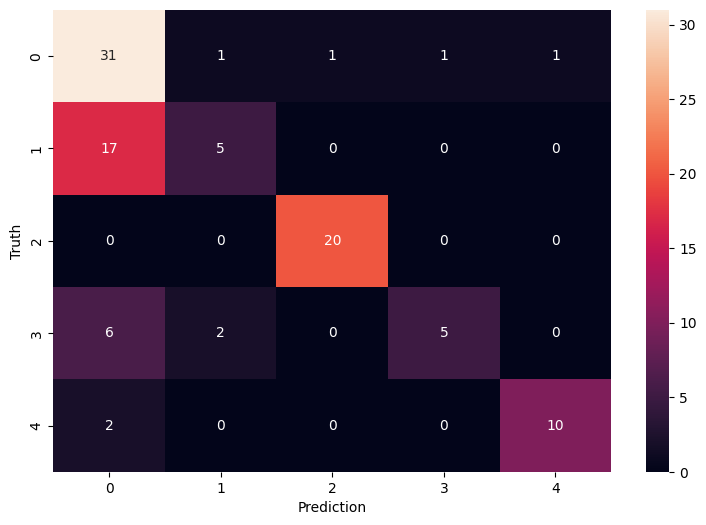

In [28]:
# Creating Confusion Matrix Diagram to help visualize output from the Gradient Boost Classifier
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (9,6))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Prediction")
plt.ylabel("Truth")

## Results & Conclusion

### Overview
My approach to creating a machine learning model for the search queries was to apply the TF-IDF vectorizer to the preprocessed search query text. My initial approach was to convert the search query text to word embedding vectors, however this produced low model performance and thus I changed how I would vectorize the data. One reason for word embeddings not being successful is because word embeddings is better for semantic similarity, and for classification type problems TF-IDF is a better technique.

Afterwards I ran the data through three model classifiers: MultinomialNB, KNeighborsClassifier, and GradientBoostingClassifier.

**Overall the GradientBoostingClassifier performed the best.** Our average F1-score (which is the harmonic mean between Precision and Recall) and accuracy was the highest with GradientBoosting compared to the other two models.

### Issues & Problems:
Across the 3 models, each had poor performance with predicting the "QA" or "1" category. One of the issues I noticed with the training dataset is that the labels are not consistent or accurately assigned.

For example, in the cell below, you'll see that the search query of "chat gpt" could be assigned to either "QA" category or "OTHER" category equally.

To enhance the performance of the models, we need to make sure our dataset is clean, standardized, and has good quality data.

### Next Steps:
If I were to enhance this analysis, I would address the class imbalance issue. I would either use SMOTE to create new samples for the underrepresented classes, and also minimize over sampled classes. If possible, I would also increase the sample size for each category so it lead to a more robust analysis.

In [29]:
print("Example of the Chat GPT Problem:")

print(df_intent[df_intent['search_query'].str.contains("chat")]['intent'].value_counts())

df_intent[df_intent['search_query'].str.contains("chat")]

Example of the Chat GPT Problem:
intent
QA       5
OTHER    5
Name: count, dtype: int64


,date,search_query,market,geo_country,device_type,browser_name,intent,daily_query_count,translated_txt,clean_txt,intent_num
60,2023-12-15,chat gpt,de-de,DE,Desktop,Safari,QA,2,chat gpt,chat gpt,1
137,2023-12-29,chat gpt,de-de,DE,Desktop,Firefox,OTHER,2,chat gpt,chat gpt,0
177,2023-12-15,chat gpt,fr-fr,FR,Desktop,Safari,QA,2,chat gpt,chat gpt,1
203,2023-12-14,chat gpt,de-de,DE,Desktop,Chrome,QA,4,chat gpt,chat gpt,1
245,2023-12-10,chatgpt,en-gb,GB,Desktop,Edge,OTHER,2,chatgpt,chatgpt,0
289,2023-12-19,chatgpt,de-de,DE,Desktop,Chrome,OTHER,2,chatgpt,chatgpt,0
315,2023-12-18,chatgpt,en-gb,GB,Desktop,Edge,OTHER,2,chatgpt,chatgpt,0
467,2023-12-25,chatgpt,de-de,DE,Mobile,Ecosia ios,OTHER,3,chatgpt,chatgpt,0
539,2023-12-13,chat gpt,de-de,DE,Desktop,Firefox,QA,2,chat gpt,chat gpt,1
584,2023-12-07,chat gpt,fr-fr,FR,Desktop,Safari,QA,5,chat gpt,chat gpt,1
